# Import libraries

In [48]:
import pyodbc
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Database connection details

In [57]:
DB = {'servername': 'RAMCO\SQLEXPRESS',
      'database': 'UnitedoutdoorsDWH'}

export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\ramco\AppData\Local\Temp\ipykernel_13476\3671513759.py:1: SyntaxWarning: invalid escape sequence '\S'
  DB = {'servername': 'RAMCO\SQLEXPRESS',


# Fetch relevant data from the database

In [58]:
# Fetch data
orders_df = pd.read_sql_query("SELECT OrderKey, OrderID FROM dbo.Sales", export_conn)
order_details_df = pd.read_sql_query("SELECT OrderKey, ProductKey, EmployeeKey, Quantity, UnitPrice FROM dbo.Sales", export_conn)

C:\Users\ramco\AppData\Local\Temp\ipykernel_13476\595822148.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders_df = pd.read_sql_query("SELECT OrderKey, OrderID FROM dbo.Sales", export_conn)
C:\Users\ramco\AppData\Local\Temp\ipykernel_13476\595822148.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_details_df = pd.read_sql_query("SELECT OrderKey, ProductKey, EmployeeKey, Quantity, UnitPrice FROM dbo.Sales", export_conn)


# Data Preperation

In [59]:
# Merge data
merged_orders_df = pd.merge(orders_df, order_details_df, on='OrderKey', how='left')

# Group by OrderID
order_summary_df = merged_orders_df.groupby('OrderID').agg({'UnitPrice': 'sum', 'Quantity': 'sum'}).reset_index()

# Visualize the clusters

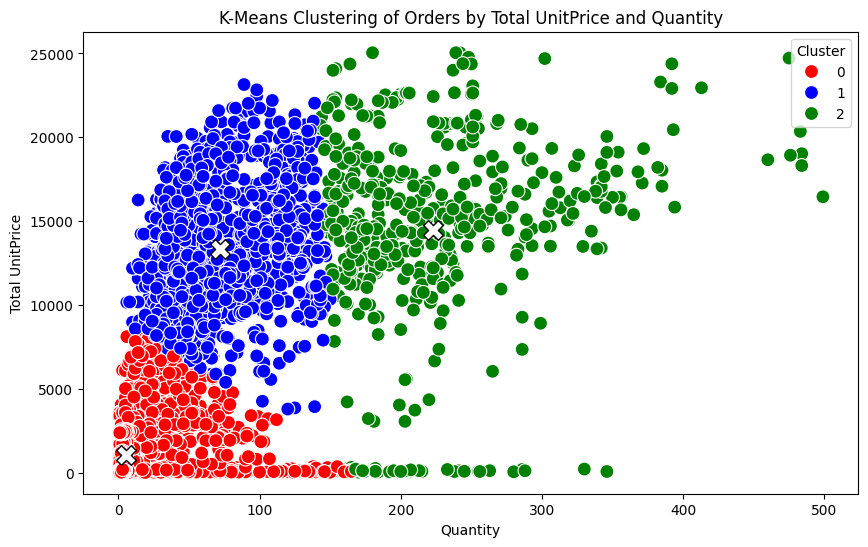

,Cluster,AvgUnitPrice,AvgQuantity
0,0,1069.351596,5.053558
1,1,13325.028607,72.138423
2,2,14462.119276,222.726358


,OrderID,UnitPrice,Quantity,Cluster
0,2001,37.00,36,0
1,2002,19.00,48,0
2,2003,23.00,36,0
3,2004,48.00,96,0
4,2005,15.00,12,0
...,...,...,...,...
32940,75119,42.28,3,0
32941,75120,84.96,3,0
32942,75121,74.98,3,0
32943,75122,30.97,2,0


In [60]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(order_summary_df[['UnitPrice', 'Quantity']])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
order_summary_df['Cluster'] = kmeans.fit_predict(scaled_data)

# Define cluster colors
cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=order_summary_df, x='Quantity', y='UnitPrice', hue='Cluster', palette=cluster_colors, s=100)

# Calculate and plot the average values for each cluster
for cluster in order_summary_df['Cluster'].unique():
    cluster_data = order_summary_df[order_summary_df['Cluster'] == cluster]
    avg_quantity = cluster_data['Quantity'].mean()
    avg_unit_price = cluster_data['UnitPrice'].mean()
    plt.scatter(avg_quantity, avg_unit_price, color='white', edgecolor='black', s=200, marker='X')

plt.title('K-Means Clustering of Orders by Total UnitPrice and Quantity')
plt.xlabel('Quantity')
plt.ylabel('Total UnitPrice')
plt.legend(title='Cluster')
plt.show()

# Calculate the average UnitPrice and Quantity for each cluster
cluster_averages = order_summary_df.groupby('Cluster').agg({'UnitPrice': 'mean', 'Quantity': 'mean'}).reset_index()
cluster_averages.columns = ['Cluster', 'AvgUnitPrice', 'AvgQuantity']

# Display the cluster averages
display(cluster_averages)

# Display the order summary with clusters
display(order_summary_df[['OrderID', 'UnitPrice', 'Quantity', 'Cluster']])